# Time series plotting around reservoirs

## To-dos
- [ ] sum precip from mm/hr to mm
- [x] spatial aggregation of GRACE subset to single time series
- [x] spatial aggregation of CYGNSS subset to single time series
- [x] spatial aggregation of IMERG subset to single time series
- [ ] convert time series functions & spatial functions to new class

In [1]:
func_dir = '/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/'

In [2]:
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append(func_dir)
import load_data
import time_series_calcs
import plotting_functions
import area_subsets
import area_calcs

In [3]:
grace_dict = load_data.load_GRACE()
precip_DA = load_data.load_IMERG()
res_shp = load_data.load_GRanD()

In [4]:
def single_timeseries_IMERG_CYGNSS_GRACE(dam_name,subset_method='polygon',**plot_params):
    """
    Description
    -----------
    Hard-coded time series slicing for IMERG and CYGNSS to start two months after the intersecting_timeframes() start date
    
    Inputs
    ------
    dam_name: name of a dam in the GRanD reservoir dataset
    subset_method : str
        default : 'polygon'
        accepted : 'polygon' , 'point'
        allows for updated polygon or older point-based subsetting
    **plot_params : dict
        dictionary of plot formatting options and labels
            Keys used: None, all passed to `three_part_timeseries`

    Outputs
    -------
    precip , fw , cmwe : Pandas Series
        Series used for plotting
        Respectively, precipitation, fractional water, TWS
    """
    global precip_DA , grace_dict, res_shp
    
    if 'polygon' in subset_method.lower():
        subset_gpd = area_subsets.check_for_multiple_dams(dam_name,res_shp)
        precip_multi , precip_full = area_subsets.precip_shape_subset(
                             subset_gpd,
                             precip_DA,
                             buffer_val=0.25,
                             crs_code=4326)
        
        subset_bbox = subset_gpd.geometry.buffer(0).bounds
        fw_DA = load_data.load_CYGNSS_001_all_months(subset_bbox.values[0])
        fw_multi , fw_full = area_subsets.cygnss_shape_subset(
                             subset_gpd,
                             fw_DA,
                             buffer_val=0.25,
                             crs_code=4326)
        fw_binary = area_calcs.cygnss_convert_to_binary(fw_multi)
        fw_num = area_calcs.CYGNSS_001_areal_average(fw_binary)
        fw_full = pd.Series(data=fw_num, index=fw_full.index)
        
        cmwe_multi , mascon_ts , cmwe_full = area_subsets.grace_shape_subset(
                                subset_gpd,
                                grace_dict,
                                buffer_val=0)        
    elif 'point' in subset_method.lower():
        coords_i = area_subsets.reservoir_name_to_point(res_oi,res_shp)
        
        precip_full = area_subsets.precip_point_subset(coords_i,precip_DA)
        fw_full = area_subsets.cygnss_point_subset(coords_i,fw_DA)
        cmwe_full , mascon_ts = area_subsets.grace_point_subset(coords_i,grace_dict)

    precip , fw , cmwe = time_series_calcs.intersecting_timeframes(precip_full,fw_full,cmwe_full,buffer=0)
    precip = precip[2:]
    fw = fw[2:]
    
    plot_params['data_labels'] = ['IMERG','CYGNSS','GRACE']
    plot_params['x_label'] = 'Time'
    plot_params['y_labels'] = ['Precip (mm/hr)', 'Fraction of surface water coverage', 'TWS water equivalence (cm)']
    plot_params['line_fmt'] = ['c-','b-','k-']
    plot_params['figsize'] = (15,6)

    plt.rc('font', size=14)
    plotting_functions.three_part_timeseries([precip , fw , cmwe],**plot_params)

    return precip , fw , cmwe

/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/area_subsets.py:220: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)
/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/area_subsets.py:220: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clip_rxr = full_rxr.rio.clip(subset_gpd.geometry.buffer(buffer_val) , subset_gpd.crs)


Projected to equal area


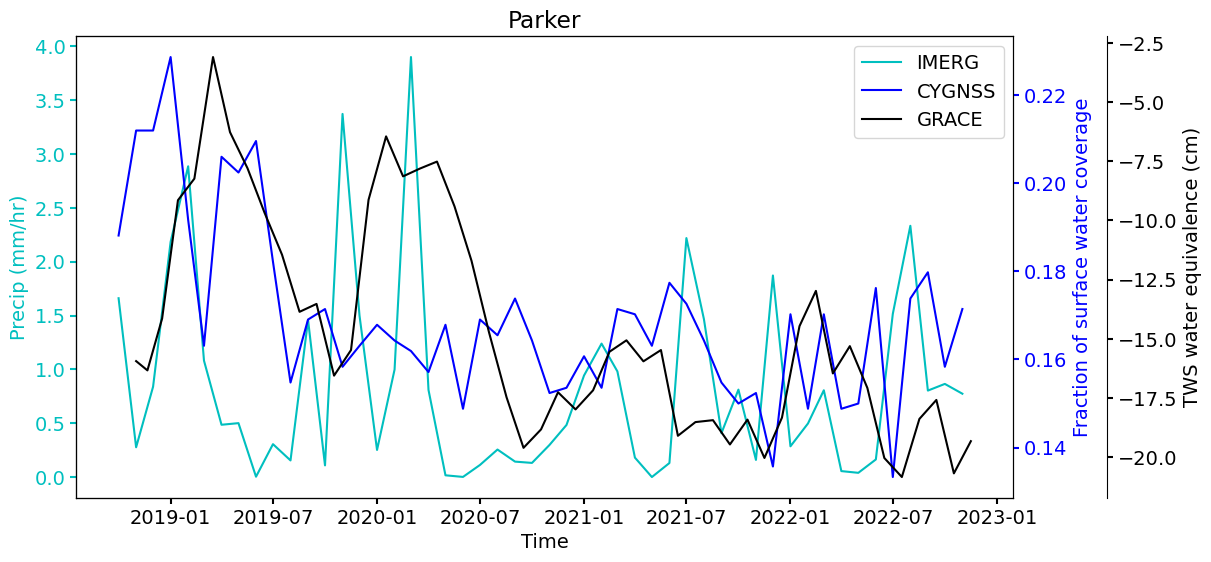

In [5]:
res_oi = 'Parker'
plot_params = {
    'title' : res_oi
}
precip_series , fw_series , cmwe_series = single_timeseries_IMERG_CYGNSS_GRACE(
    res_oi,
    **plot_params,
    subset_method='polygon')

## Older time series metrics from TSM class objects

In [6]:
def series_to_TSM_object(input_series,*TSM_args,**TSM_kwargs):
    series_obj = input_series.astype(float)
    series_obj.index = list(map(time_series_calcs.toYearFraction,series_obj.index))
    TSM_obj = time_series_calcs.TimeSeriesMetrics(series_obj,*TSM_args,**TSM_kwargs)
    return TSM_obj

In [7]:
precip_ts = series_to_TSM_object(precip_series,'IMERG',remove_seasonality=True,zero_start=False)
fw_ts = series_to_TSM_object(fw_series,'CYGNSS',remove_seasonality=True,zero_start=False)
cmwe_ts = series_to_TSM_object(cmwe_series,'GRACE',remove_seasonality=True,zero_start=False)

Calculating seasonality.
Calculating seasonality.
Calculating seasonality.


/tmp/ipykernel_14350/540654337.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(),rotation=-90)
/tmp/ipykernel_14350/540654337.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,1].set_xticklabels(axs[0,1].get_xticklabels())


---cross correlation----
Between CYGNSS and GRACE
Max correlation of 0.356 occurs with time shift of  4
---cross correlation----
Between CYGNSS and GRACE
Max correlation of 0.281 occurs with time shift of  -7


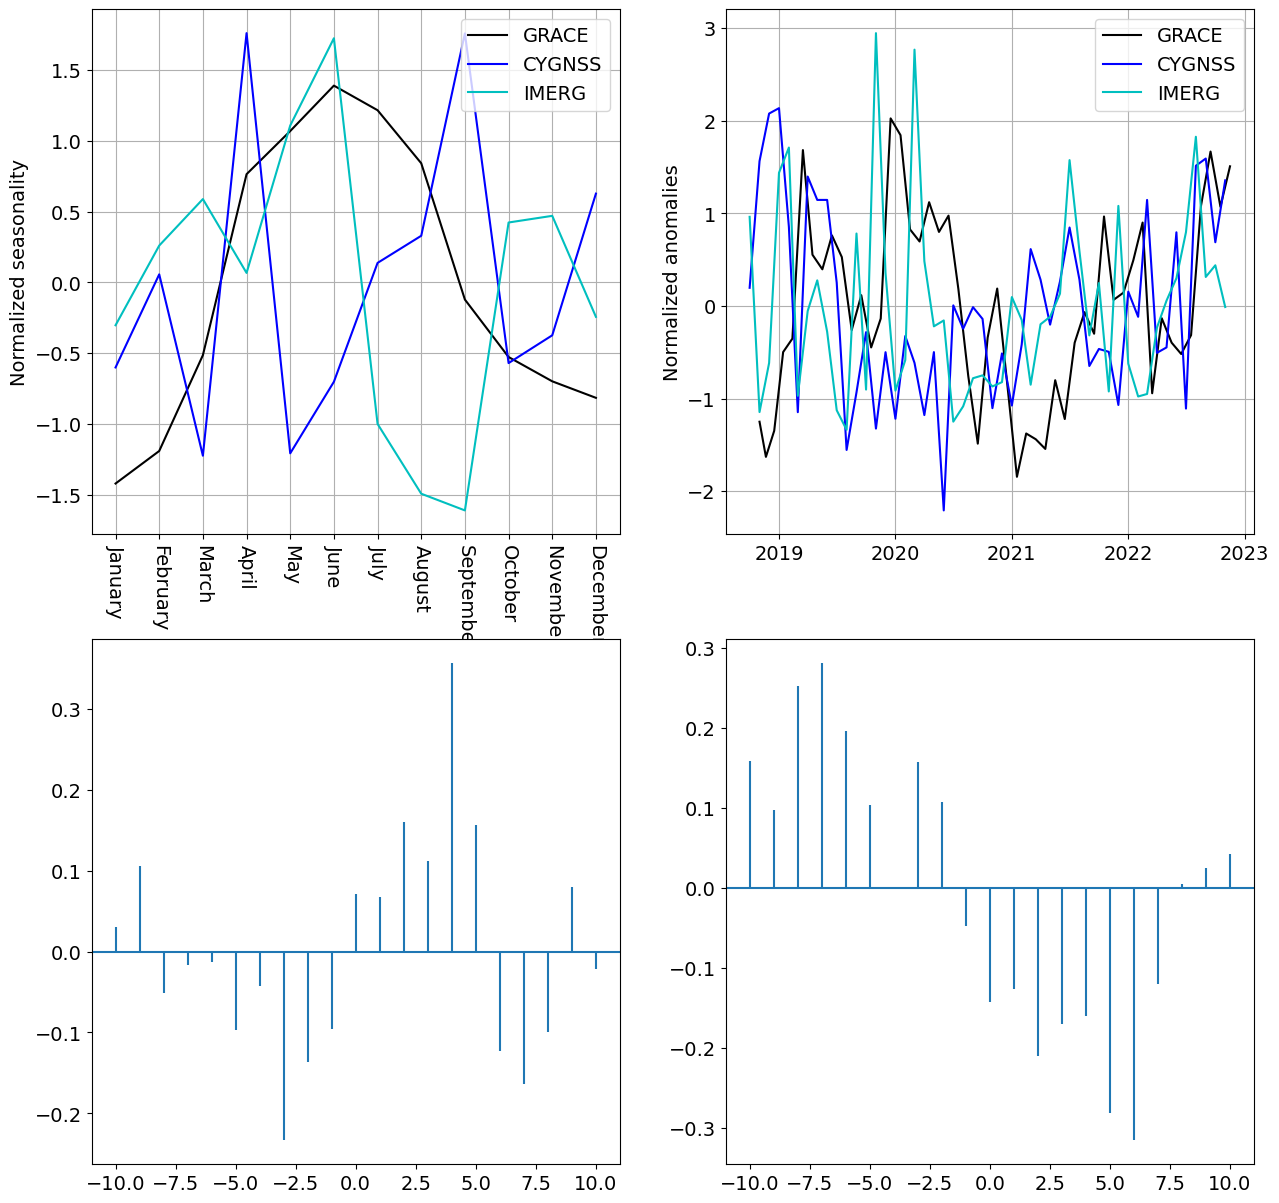

In [12]:
def quick_quad_xcorr_figure(input3TSMs,**plot_params):
    fig , axs = plt.subplots(2,2,figsize=(15,15))
    
    #Seasonality plot
    input3TSMs[0].plot_seasonality(axs[0,0],color='k',label='GRACE')
    input3TSMs[1].plot_seasonality(axs[0,0],color='b',label='CYGNSS')
    input3TSMs[2].plot_seasonality(axs[0,0],color='c',label='IMERG')
    axs[0,0].set_ylabel('Normalized seasonality')
    axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(),rotation=-90)
    axs[0,0].grid()
    axs[0,0].legend();
    
    #Anomalies plot
    input3TSMs[0].plot_anomalies(axs[0,1],color='k',label='GRACE')
    input3TSMs[1].plot_anomalies(axs[0,1],color='b',label='CYGNSS')
    input3TSMs[2].plot_anomalies(axs[0,1],color='c',label='IMERG')
    axs[0,1].set_ylabel('Normalized anomalies')
    axs[0,1].set_xticklabels(axs[0,1].get_xticklabels())
    axs[0,1].grid()
    axs[0,1].legend();
    
    #Seasonality xcorr
    lag_x , lag_y = fw_ts.cross_corr(cmwe_ts,axs[1,0],ts_type='season',plot_on=False);
    
    #Anomalies xcorr
    lag_x , lag_y = fw_ts.cross_corr(cmwe_ts,axs[1,1],plot_on=True)
quick_quad_xcorr_figure([cmwe_ts,fw_ts,precip_ts])

In [ ]:
fig , ax = plt.subplots()
cmwe_ts.plot_seasonality(ax,color='k',label='GRACE')
fw_ts.plot_seasonality(ax,color='b',label='CYGNSS')
precip_ts.plot_seasonality(ax,color='c',label='IMERG')
ax.set_ylabel('Normalized seasonality')
ax.set_xticklabels(ax.get_xticklabels(),rotation=-90)
ax.grid()
ax.legend();

In [ ]:
print(cmwe_ts.lintrend_metrics)
fig , ax = plt.subplots()
cmwe_ts.plot_anomalies(ax,color='k',label='GRACE')
fw_ts.plot_anomalies(ax,color='b',label='CYGNSS')
precip_ts.plot_anomalies(ax,color='c',label='IMERG')
ax.legend();
ax.grid()

In [ ]:
lag_x , lag_y = cmwe_ts.cross_corr(precip_ts,ts_type='season',plot_on=True)
lag_x , lag_y = fw_ts.cross_corr(cmwe_ts,ts_type='season',plot_on=True);
lag_x , lag_y = fw_ts.cross_corr(precip_ts,ts_type='season',plot_on=True)

In [13]:
lag_x , lag_y = cmwe_ts.cross_corr(precip_ts,plot_on=True)
lag_x , lag_y = fw_ts.cross_corr(cmwe_ts,plot_on=True)
lag_x , lag_y = fw_ts.cross_corr(precip_ts,plot_on=True)

TypeError: TimeSeriesMetrics.cross_corr() missing 1 required positional argument: 'ax'

## Scratchwork

In [ ]:
def IMERG_timestamp_to_pdTimestamp(input_xrcoord):
    dates_precip = np.array(list(map(lambda x: pd.Timestamp('1980-01-06') + pd.DateOffset(seconds=x),input_xrcoord.values)))
    return dates_precip

In [ ]:
precip_multi , precip_full = area_subsets.precip_shape_subset(
                        subset_gpd,
                        precip_DA,
                        buffer_val=0.25,
                        crs_code=4326)

In [ ]:
test_bbox.values[0]

In [ ]:
subset_gpd = area_subsets.check_for_multiple_dams('Indirasagar',res_shp,idx=0)
test_bbox = subset_gpd.geometry.buffer(0).bounds

test_cygnss = load_data.load_CYGNSS_001_all_months(test_bbox.values[0])
for i in np.arange(4):
    plt.figure()
    test_cygnss[i,:,:].plot()

In [ ]:
area_subsets.reservoir_name_to_point('Xiaowan',res_shp) , area_subsets.reservoir_name_to_point('Nuozhadu',res_shp)

In [ ]:
res_shp[res_shp['DAM_NAME'] =='Sardar Sarovar'].squeeze()

In [ ]:
res_shp.loc[res_shp['RIVER'] == 'Narmada',['DAM_NAME','RES_NAME','COUNTRY','MAIN_USE','YEAR','CAP_MCM','LONG_DD','LAT_DD']].sort_values('CAP_MCM',ascending=False)

In [ ]:
res_shp[res_shp['ADMIN_UNIT'] == 'Yunnan']

In [ ]:
res_shp.loc[:,['DAM_NAME','COUNTRY','MAIN_USE','YEAR','CAP_MCM']].sort_values('CAP_MCM',ascending=False)

In [ ]:
res_shp.loc[res_shp['MAIN_BASIN'] == 'Mekong',['DAM_NAME','COUNTRY','MAIN_USE','YEAR','CAP_MCM','LONG_DD','LAT_DD']].sort_values('CAP_MCM',ascending=False)